In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from util.util_cnn import *
from util.util_lrp import *
from util.naming import *

from util.util_gamma_rule import calc_vals_batch
from util.util_data_summary import *
from util.vgg import *

import torchvision
from torchvision import transforms, datasets

from util.ig import IntermediateIntegratedGradients

model_dict = load_mnist_v4_models()
model_d3 = model_dict['cb1-8-8-8_cb2-16-16-16_seed-0']
data, target = first_mnist_batch(batch_size=8400)
data.shape

torch.Size([8400, 1, 28, 28])

In [29]:
# all layers use gamma, go to layer 0

n_points = 100
normalized = True
delete_unactivated_subnetwork = 'mask'
no_gamma_in_fc = False

l_out = 15
l_inp = 0

mode_str = 'all_conv_gamma' if no_gamma_in_fc else 'all_gamma'

key = f'__{l_out}_to_{l_inp}__testset{n_points}__{mode_str}__gammas80'
if not normalized: key += '__unnormalized'
if not delete_unactivated_subnetwork: key += '__all_logits'

mat_funcs = [partial(LRP_global_mat, model=model_d3, l_lb=-50, l_ub=15, l_inp=l_inp, l_out=l_out, normalized=normalized, delete_unactivated_subnetwork=delete_unactivated_subnetwork)]
calc_mats_batch_functional(mat_funcs, gammas80, data[:n_points], pickle_key=('d3', 'LRP'+key), tqdm_for='point', overwrite=True)

mats = load_data('d3', 'LRP'+key)

100%|██████████| 100/100 [36:06<00:00, 21.67s/it]


Matrices vals under key: ('d3', 'LRP__15_to_0__testset100__all_gamma__gammas80')
Saved: ./pickle/d3/LRP__15_to_0__testset100__all_gamma__gammas80.pickle
Attempt loading: d3 LRP__15_to_0__testset100__all_gamma__gammas80


In [2]:
%matplotlib inline

# Low dimensional toy model 
- plot development of gradients as we approach baseline

In [227]:
class ToyModel(nn.Module):
    def __init__(self, x_0, x_1, hidden_sizes=[2], seed=42):
        super().__init__()

        # Set the seed for random initialization
        if seed is not None:
            torch.manual_seed(seed)

        self.x_0 = torch.tensor(x_0, dtype=torch.float, requires_grad=True)
        self.x_1 = torch.tensor(x_1, dtype=torch.float, requires_grad=True)
        self.x_0.retain_grad()
        self.x_1.retain_grad()

        assert self.x_0.shape == self.x_1.shape and self.x_0.ndim == 1

        activation_sizes = [len(self.x_0)] + hidden_sizes + [1]

        # Define linear layers and initialize weights and biases randomly
        self.layers = nn.ModuleList()  # Use ModuleList to store layers
        for inp, out in zip(activation_sizes[:-1], activation_sizes[1:]):
            layer = nn.Linear(inp, out, bias=True)
            # Initialize weights and biases randomly
            nn.init.normal_(layer.weight, mean=0, std=0.4)
            nn.init.normal_(layer.bias, mean=.5, std=0.2)
            self.layers.append(layer)


    def forward(self, t):
        assert 0 <= t <= 1
        self.activations = []
        
        x = self.x_1 * (1-t) + self.x_0 * t
        x.retain_grad()
        self.activations.append(x)  # Store the input (x) activation

        for layer in self.layers:
            h = F.relu(layer(self.activations[-1]))
            h.retain_grad()
            self.activations.append(h)

        return self.activations[-1]

In [228]:
inputs = torch.tensor([[2,-3,5]])
outputs = torch.tensor([[0,0,0]])

/var/folders/3h/t42_2k2d0tqf3gl1_tjslcbr0000gn/T/ipykernel_13365/3698739428.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_0 = torch.tensor(x_0, dtype=torch.float, requires_grad=True)
/var/folders/3h/t42_2k2d0tqf3gl1_tjslcbr0000gn/T/ipykernel_13365/3698739428.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_1 = torch.tensor(x_1, dtype=torch.float, requires_grad=True)


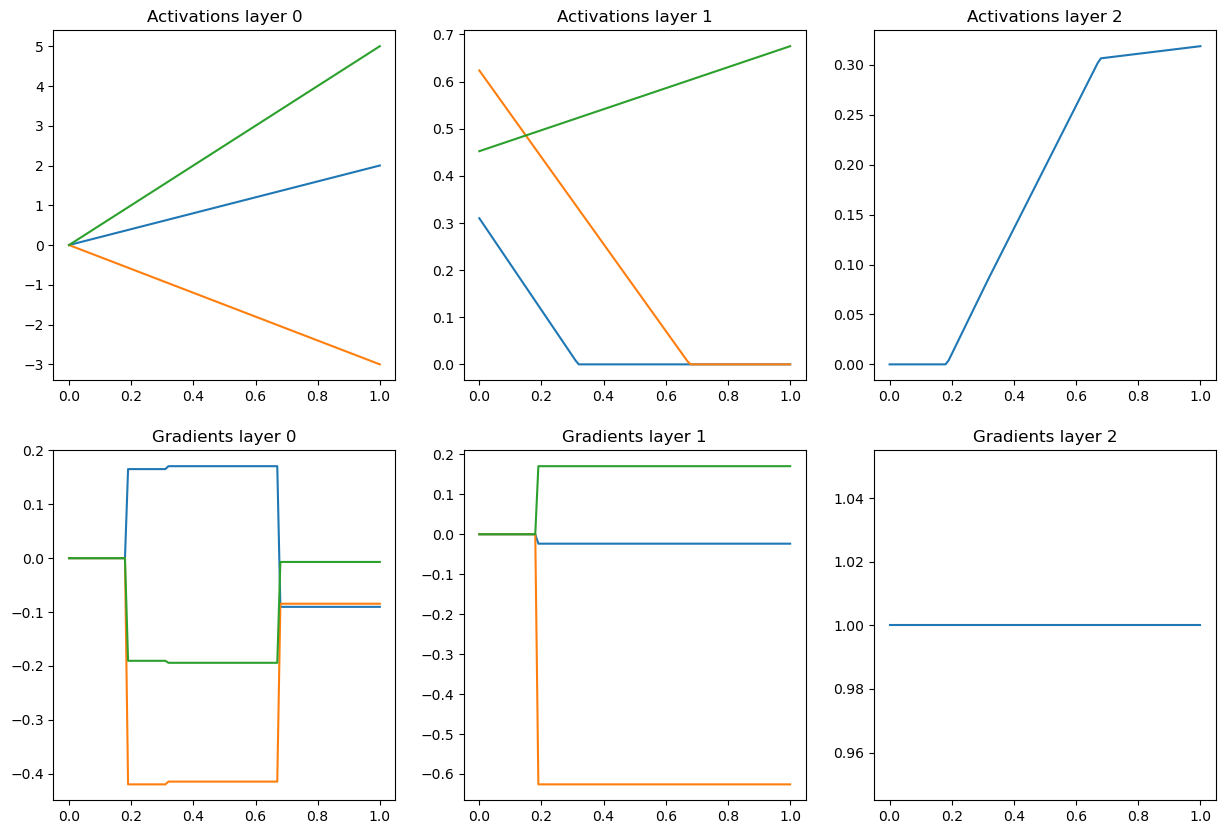

In [229]:
m = ToyModel(inputs[0], outputs[0], hidden_sizes=[3], seed=2)

Activations = []
Gradients = []
T = np.linspace(0, 1, 101)

for t in T:
    m.zero_grad()  # Clear previous gradients
    m.forward(torch.tensor(t, requires_grad=True, dtype=torch.float)).backward(retain_graph=True)
    # Collect values
    Activations.append({ ind: d.detach().numpy() for ind, d in enumerate(m.activations)})
    Gradients.append({ ind: d.grad.detach().numpy() for ind, d in enumerate(m.activations)})

# Plot activations
n_plots = len(Activations[0])
fig, axs = plt.subplots(2, n_plots, figsize=(5*n_plots, 10))
for name, df, ax_row in zip(['Activations', 'Gradients'], [pd.DataFrame(Activations), pd.DataFrame(Gradients)], axs):
    for ax, col in zip(ax_row, df.columns):
        arr = np.array(df[col].to_list())
        ax.plot(T, arr)
        ax.set_title(f"{name} layer {col}")

plt.show()

# Captum on MNIST model

In [230]:
# import gauss_legendre_builders from captum:
from captum.attr._utils.approximation_methods import gauss_legendre_builders
from captum.attr._utils.common import _format_input_baseline
from captum.attr import IntegratedGradients

In [231]:
step_sizes, alphas = gauss_legendre_builders()

In [232]:
from captum._utils.common import (
    _expand_additional_forward_args,
    _expand_target,
    _format_additional_forward_args,
    _format_output,
    _is_tuple
)
from captum.attr._utils.common import (
    _format_input_baseline,
    _reshape_and_sum,
    _validate_input,
)
from captum.attr._utils.approximation_methods import approximation_parameters

In [233]:


n = 1000
selected = [0,1,5,10,50,-51,-11,-6,-2,-1]
i_image = 2

ig_data = data[i_image:i_image+1].repeat(n,1,1,1)
ig_target = target[i_image:i_image+1].repeat(n)
ig_baseline = ig_data.detach().clone() * torch.linspace(0, 1, n).flip(0).reshape(n,1,1,1)

ig_data = ig_data[selected]
ig_target = ig_target[selected]
ig_baseline = ig_baseline[selected]

# applying integrated gradients on the SoftmaxModel and input data point
ig = IntegratedGradients(model_d3)
attributions, approximation_error = ig.attribute(ig_data, baselines=ig_baseline, target=ig_target,
                                    return_convergence_delta=True)

attributions = attributions.clone().detach().numpy()[:, 0]

# attributions, \
approximation_error

tensor([ 0.0000e+00,  8.0140e-07,  3.5636e-06, -6.6025e-06,  3.1097e-05,
        -1.0790e-02, -8.7734e-02,  1.3324e-01, -1.0204e-01,  1.5501e-02],
       dtype=torch.float64)

# My IG implementation

## Run on VGG

In [241]:
cat16 = load_cat16()
model = torchvision.models.vgg16(pretrained=True); model.eval()

FileNotFoundError: [Errno 2] No such file or directory: './dataset/cat16'

In [ ]:
model

In [ ]:
class FlattenExceptBatch(nn.Module):
    def forward(self, x):
        batch_size = x.size(0)
        return x.view(batch_size, -1)

vgg_layers = list(model.features) + [model.avgpool, FlattenExceptBatch()] + list(model.classifier)

vgg_linear_layer_idx = []
for i, layer in enumerate(vgg_layers):
    n = layer.__class__.__name__
    if n in ['Conv2d',
            #  'MaxPool2d', 'AvgPool2d',
             'Linear']:
        vgg_linear_layer_idx.append(i)
        
        print('=', i, layer)
    else:
        print(' ', i, layer)


In [ ]:
iig = IntermediateIntegratedGradients(vgg_layers)
grads = iig.batch_attribute(cat16, measure_at_layers=vgg_linear_layer_idx, all_logits=False, multiply_by_inputs=False)
# grads = iig.batch_attribute(cat16, measure_at_layers=vgg_linear_layer_idx, all_logits=False, multiply_by_inputs=False)
# i_grads = iig.batch_attribute(cat16[:1], measure_at_layers=vgg_linear_layer_idx, all_logits=False, multiply_by_inputs=True, n_steps=100, baselines_at_steps=[100])

print(len(grads), grads[0].shape)
print(type(grads), type(grads[0]), type(grads[0][0]), type(grads[0][0][0]), type(grads[0][0][0][0]))

### Svals

In [ ]:
svals_grads = calc_vals_batch(grads, num_vals='auto', tqdm_for='point', return_vecs=False)
# svals_i_grads = calc_vals_batch(i_grads, num_vals='auto', tqdm_for='point', return_vecs=False)

print(svals_grads.shape)
print(svals_i_grads.shape)

### Condition number of increasing subsections of the backward pass

#### Gradient

In [ ]:
svals_grads.shape

In [ ]:
mask0 = ((svals_grads != 0).sum(axis=(3), keepdims=True) != 0) * np.ones_like(svals_grads, dtype=bool)
mask0.shape

In [ ]:
mask0 = ((svals_grads != 0).sum(axis=(3), keepdims=True) != 0) * np.ones_like(svals_grads, dtype=bool)
mask0 = ((svals_grads != 0).sum(axis=(0,2,3)) != 0)
vals = svals_grads[:, mask0].transpose((2,1,0,3))
g = vgg_linear_layer_idx

fig, axs = plot_condition_number(vals, g, ylim=(2, 1e3), sharey=True, mode='lines', xlim=(min(g), max(g)), xscale='linear')
# annotate_axs_d3_individual_gamma(axs, n_expected=5, left=True)

### Relevance Preservation

In [ ]:
# col_sums_i_grads     = np.array([        for_one_matrix.sum(axis=-1) for for_one_matrix in i_grads])
# col_sums_i_grads_abs = np.array([np.abs(for_one_matrix).sum(axis=-1) for for_one_matrix in i_grads])

col_sums_grads     = np.array([        for_one_matrix.sum(axis=-1) for for_one_matrix in grads])
col_sums_grads_abs = np.array([np.abs(for_one_matrix).sum(axis=-1) for for_one_matrix in grads])

n_weights, n_points, n_configs, n_vals = col_sums_grads_abs.shape
# assert col_sums_i_grads_abs.shape == col_sums_grads_abs.shape, "Following reshapes are based on this assumption."
print(n_weights, n_points, n_configs, n_vals)

#### IG

In [ ]:
v = col_sums_i_grads.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

In [ ]:
v = col_sums_i_grads_abs.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

#### Grads

In [ ]:
v = col_sums_grads.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=vgg_linear_layer_idx, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

for axr in axs:
    maxi = np.percentile(np.abs(col_sums_grads), 99.7)
    for ax in axr:
        ax.set_yscale('linear')
        ax.set_ylim(-maxi, maxi)

In [ ]:
v = col_sums_grads_abs.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=vgg_linear_layer_idx, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

## MNIST

In [7]:
n_points = 4000

iig = IntermediateIntegratedGradients(model_d3.seq)

## takes 15 min + 10 min forwriting to disk:
if False:
    i_grads = iig.batch_attribute_pool(data[:n_points], measure_at_layers=d3_before_all_conv, all_logits=False, multiply_by_inputs=True, n_steps=50, n_classes=10, n_processes=20)
    save_data('d3', f'Rels__m0_to_t__testset{n_points}__ig50', i_grads)
    if l_out == 'm0': # Rel0 only makes sense in the last layer, as we need the target class.
        save_data('d3', f'Rel0__m0_to_0__testset{n_points}__ig50', {'50/50': i_grads[0][np.arange(4000), 0, target[:4000]].reshape([4000, 1, 28, 28])})
else:
    i_grads   = load_data('d3', f'Rels__m0_to_t__testset{n_points}__ig50') # ig for all layers. tuple of 7 large arrays. 150GB in size
    if l_out == 'm0': # Rel0 only makes sense in the last layer, as we need the target class.
        ig_input = load_data('d3', f'Rel0__m0_to_0__testset{n_points}__ig50') # dict following convention of run-pixflip-pool.py. only for input layer, only for target class, shape (1, 28, 28).
        print(ig_input.keys(), ig_input[next(iter(ig_input))].shape)

print(len(i_grads), i_grads[0].shape)

Attempt loading: d3 Rels__m0_to_t__testset4000__ig50
Missing file: ./pickle/d3/Rels__m0_to_t__testset4000__ig50.pickle


TypeError: object of type 'bool' has no len()

In [8]:
n_points = 100
normalized = True
times_input = True
all_logits = False

l_out, n_classes = 15, 256 # adapt number of neurons if you change the layer

key = f'__testset{n_points}__ig50'
if not normalized: key += '__unnormalized'
if not times_input: key += '__woI'
if all_logits: key += '__all_logits'

submodel = model_d3.seq[:l_out]
iig = IntermediateIntegratedGradients(submodel)

print(key)

# Assuming n_points = 4000. takes 15 min + 10 min forwriting to disk:
if False:
    i_grads = iig.batch_attribute_pool(data[:n_points], measure_at_layers=d3_before_all_conv, all_logits=all_logits, n_steps=50, n_classes=n_classes, n_processes=20, normalize = normalized, multiply_by_inputs = times_input)
    save_data('d3', f'Rels__{l_out}_to_t' + key, i_grads)
    n_steps = i_grads[0].shape[1]
    if l_out == 'm0': # Rel0 only makes sense in the last layer, as we need the target class.
        dic = {f'{i_step+1:03d}/{n_steps:03d}':
            i_grads[0][np.arange(n_points), i_step, target[:n_points]].reshape([n_points, 1, 28, 28])
            for i_step in range(n_steps)}
        save_data('d3', f'Rel0__{l_out}_to_0' + key, dic)

else:
    i_grads  = load_data('d3', f'Rels__{l_out}_to_t' + key) # ig for all layers. tuple of 7 large arrays. 150GB in size
    if l_out == 'm0': # Rel0 only makes sense in the last layer, as we need the target class.
        ig_input = load_data('d3', f'Rel0__{l_out}_to_0' + key) # dict following convention of run-pixflip-pool.py. only for input layer, only for target class, shape (1, 28, 28).

        print(ig_input.keys(), ig_input[next(iter(ig_input))].shape)

__testset100__ig50
Attempt loading: d3 Rels__15_to_t__testset100__ig50


In [11]:
n_points = 100
normalized = True
times_input = True
all_logits = False
n_points_save = 100

first_p = None
first_p, prefilter_positive_activations = 40, True

key = f'__testset{n_points}__ig50'
if not normalized: key += '__unnormalized'
if not times_input: key += '__woI'
if all_logits: key += '__all_logits'
if first_p: key += f'__p{first_p:03}'


l_out = 'm0' # (this indicates the last layer)
l_out = 15
submodel = model_d3.seq[:l_out]

key = f'__{l_out}_to_t' + key
print(key)

__15_to_t__testset100__ig50__p040


In [29]:
prefilter_positive_activations, first_p = True, 80

# some of these parametrizations are not reflected correctly in the file names or function calls!

n_points = 100
normalized = True
times_input = True
all_logits = False

l_out = 'm0' # (this indicates the last layer)
l_out = 15

key_rels = f'__{l_out}_to_t__testset{n_points}__ig50'
key =      f'__{l_out}_to_0__testset{n_points}__ig50' # we only save mats and later calculate svals for attribution towards input neurons (l_in=0) not intermediate neurons.

if not normalized: key += '__unnormalized'
if not times_input: key += '__woI'
if all_logits: key += '__all_logits'
if first_p: key += f'__p{first_p:03}'

submodel = model_d3.seq[:l_out]

if True:
    from util.data_wrangling import mask_unactivated__normalize__reshape
    
    # i_grads = load_data('d3', 'Rels'+key_rels) # ig for all layers. tuple of 7 large arrays. 150GB in size
    
    # we only save mats and later calculate svals for attribution towards input neurons (l_in=0) not intermediate neurons.
    # thus we select only the first subsection and reexpand the first dimension:
    mats = i_grads[0][None, ...] 

    output = submodel(data[:len(i_grads[0])]).detach()
    mats = mask_unactivated__normalize__reshape(mats, output, normalize=normalized, first_p = first_p, prefilter_positive_activations=prefilter_positive_activations)
    save_data("d3", 'mats'+key, mats)
else:
    mats = load_data("d3", 'mats'+key)
 

subsection 0: (100, 50, 256, 784)  ->  (100, 50) (85, 784)
Saved: ./pickle/d3/mats__15_to_0__testset100__ig50__p080.pickle


In [30]:
if True:
    svals = calc_vals_batch(mats, num_vals='auto', tqdm_for='point', return_vecs=False)
    save_data("d3", 'svals'+key, svals)
else:
    svals = load_data("d3", 'svals'+key)

100it [03:39,  2.19s/it]

Saved: ./pickle/d3/svals__15_to_0__testset100__ig50__p080.pickle


## Svals with normalized matrices

In [9]:
ylim = (1,1000)

d = condition_number(svals, percentile=.95)[:, :, [0, -1]]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(10, 5), sharey=True, sharex=True)
for ax, d in zip(axs, d):    
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim(ylim)
    ax.set_xticks((1, 2))
    ax.set_xticklabels(('GxI', 'IG'))

AttributeError: 'bool' object has no attribute 'shape'

## Svals

(7, 10)


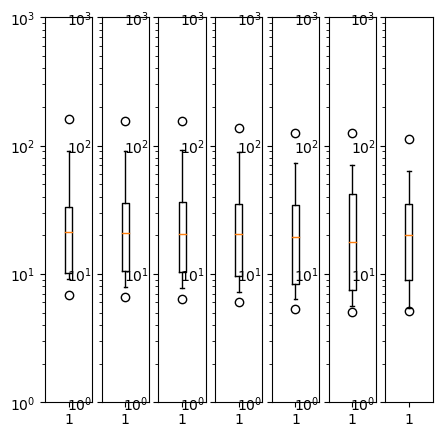

In [ ]:
ylim = (1,1000)

d = condition_number(svals_grads, percentile=.95)[:, :, 0]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
for ax, d in zip(axs, d):    
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim(ylim)

In [21]:
svals.shape

(7, 100, 50, 7)

(7, 100, 2)


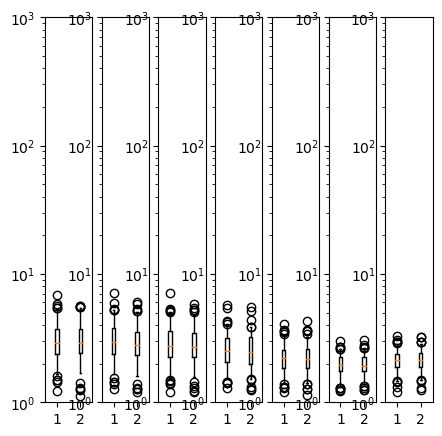

In [23]:
ylim = (1,1000)

d = condition_number(svals, percentile=.95)[:, :, [0, -1]]
print(d.shape)
# boxplot vertical, log scaled y axis:
fig, axs = plt.subplots(1, len(d), figsize=(5, 5))
for ax, d in zip(axs, d):    
    ax.set_yscale('log')
    ax.boxplot(d, vert=True, showfliers=True, whis=[5, 95])
    ax.set_ylim(ylim)

In [ ]:
## L1 operator norm of IG 
print(len(i_grads), i_grads[0].shape)
np.abs(i_grads[0][4]).sum(axis=(1,2)).max()

7 (4000, 50, 10, 784)


27.575253

### Check how well they fulfill relevance preservation.
They only do it relatively well, when the root point is 0. (for intermediate rootpoitns the function does not eval to 0.)

In [ ]:
for grads_for_parameter in i_grads[0].transpose((1,0,2,3)):
    sums_for_parameter = []
    for grads_for_point in grads_for_parameter:
        class_is_activated = np.any(grads_for_point != 0, axis=1)
        sums = grads_for_point[class_is_activated].sum(axis=1)
        sums_for_parameter += list(sums)
        
    sums_for_parameter = np.array(sums_for_parameter)
    print(np.percentile(sums_for_parameter, [0, 5, 50, 95, 100]))

[-2.45024323  0.71453128  0.98214817  1.26786081  9.53699017]
[-1.85886538  0.70098782  0.98168766  1.27772717  9.20287132]
[-1.75483119  0.71502793  0.97946709  1.26522281  9.56666756]
[-1.77121449  0.72323541  0.97775626  1.28045747  9.65727043]
[-1.77590692  0.69094143  0.9781661   1.27694369  9.83325386]
[-1.7330097   0.67910422  0.97620198  1.27139705  9.87025642]
[-1.64373076  0.6712222   0.97199959  1.27034318  9.85007   ]
[-1.5846684   0.66516534  0.97049952  1.273633    9.85974312]
[-1.57001829  0.69757869  0.96920848  1.2737547   9.73424339]
[-1.51565397  0.70868747  0.96895096  1.26946893  9.38553429]
[-1.53754938  0.67648699  0.96830356  1.26410565  9.32161427]
[-1.55003119  0.67721804  0.96945113  1.26264527  9.06372929]
[-1.56748772  0.68081487  0.97086218  1.27723913  8.70298958]
[-1.54899919  0.65727651  0.97237021  1.29667519  8.4096899 ]
[-1.49337232  0.65823947  0.97316292  1.29986311  8.11336327]
[-1.47934639  0.66031536  0.97519207  1.29853194  7.78903437]
[-1.4534

### Eval with PixelFlipping

In [ ]:
import quantus

In [ ]:
device=torch.device("mps")
model=model_d3
model.eval()
model.to(device)

def flipScores(x_batch, y_batch, a_batch):
    return pixFlipMetric(

        model=model,
        x_batch=x_batch,
        y_batch=y_batch,
        a_batch=a_batch,
        device=device
    )

x_batch = data.numpy()
y_batch = target.numpy()
# integration_step = -1

perturb_func=None
perturb_baseline="mean"
for perturb_baseline in ["mean", "black", "white"]:
    for integration_step in [49, 0]:
        a_batch = i_grads[0][np.arange(len(i_grads[0])), integration_step, y_batch, :]
        a_batch = a_batch.reshape((-1, 1, 28, 28))

        pixFlipMetric = quantus.PixelFlipping(disable_warnings = True, perturb_func=perturb_func, perturb_baseline=perturb_baseline)

        n = 40
        np.random.seed(42)
        scores = []
        assert len(x_batch) == len(y_batch) == len(a_batch), f"Not matching shape: {x_batch.shape}, {y_batch.shape}, {a_batch.shape}"

        for i in tqdm(range(0, len(a_batch), n)):
            # create minibatches to pass to pixflip system
            xb = x_batch[i:i+n]
            yb = y_batch[i:i+n]
            ab = a_batch[i:i+n]
            assert len(xb) == len(yb) == len(ab), f"Not matching shape: {xb.shape}, {yb.shape}, {ab.shape}"

            minibatch_scores = flipScores(xb, yb, ab)
            scores.append(minibatch_scores)

        shared_dict_scores = {}
        shared_dict_scores[f"ig_{integration_step+1}"] = { 'PixFlip': np.concatenate(scores, axis=0) }
        key = f'PixFlipScores__testset__{perturb_baseline}__ig_{integration_step+1}'
        save_data('d3', key, shared_dict_scores)
        print("saved", key)

## Check validity of generated matrics

Column sums to check preservation

In [ ]:
grads[0].shape

In [ ]:
grads[0][0,0].sum(axis=1)

In [ ]:
for g in i_grads:
    for p in g[:8]:
        for sum in p[0].sum(axis=1):
            print(f"{sum:5.2f} " if sum else '.', end='')
        print(' | ', end='')
    print()


In [ ]:
for g in i_grads:
    for p in g[:8]:
        for sum in np.abs(p[0]).sum(axis=1):
            print(f"{sum:5.2f} " if sum else '.', end='')
        print(' | ', end='')
    print()


### Violin plot (across all classes)

In [ ]:
col_sums_i_grads     = np.array([        for_one_matrix.sum(axis=-1) for for_one_matrix in i_grads])
col_sums_i_grads_abs = np.array([np.abs(for_one_matrix).sum(axis=-1) for for_one_matrix in i_grads])

col_sums_grads     = np.array([        for_one_matrix.sum(axis=-1) for for_one_matrix in grads])
col_sums_grads_abs = np.array([np.abs(for_one_matrix).sum(axis=-1) for for_one_matrix in grads])

n_weights, n_points, n_configs, n_vals = col_sums_i_grads_abs.shape
assert col_sums_i_grads_abs.shape == col_sums_grads_abs.shape, "Following reshapes are based on this assumption."
print(n_weights, n_points, n_configs, n_vals)

#### IG

In [ ]:
v = col_sums_i_grads.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

In [ ]:
v = col_sums_i_grads_abs.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

#### Grads

In [ ]:
v = col_sums_grads.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

for axr in axs:
    maxi = np.percentile(np.abs(col_sums_grads), 99.7)
    for ax in axr:
        ax.set_yscale('linear')
        ax.set_ylim(-maxi, maxi)

In [ ]:
v = col_sums_grads_abs.transpose((2,1,3,0)).reshape((n_configs, n_points*n_vals, n_weights, 1))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

#### Violin plot (per class)

In [ ]:
v = col_sums_i_grads.transpose((3,1,2,0)).reshape((n_vals, n_points, n_weights, n_configs))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True, sharey=True)

In [ ]:
v = col_sums_i_grads_abs.transpose((3,1,2,0)).reshape((n_vals, n_points, n_weights, n_configs))
fig, axs = distribution_plot(v, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True, sharey=True)

# Line plot

## Condition number of increasing subsections of the backward pass

#### Gradient

In [ ]:
svals_grads.shape

In [ ]:
vals = svals_grads.transpose((2,1,0,3))

fig, axs = plot_condition_number(vals, d3_before_all_conv, ylim=(2, 1e3), sharey=True, mode='lines', xlim=(min(g), max(g)), xscale='linear')
# annotate_axs_d3_individual_gamma(axs, n_expected=5, left=True)

In [ ]:
vals = svals_grads.transpose((2,1,0,3))
fig, axs = distribution_plot(vals, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

#### IG

In [ ]:
vals = svals_i_grads.transpose((2,1,0,3))

fig, axs = plot_condition_number(vals, d3_before_all_conv, ylim=(2, 1e3), sharey=True, mode='lines', xlim=(min(g), max(g)), xscale='linear')
# annotate_axs_d3_individual_gamma(axs, n_expected=5, left=True)
for ax in np.array(axs).flatten():
    ax.set_xticks(d3_before_all_conv)
    ax.set_xticklabels([f"({l} <- T)" for l in d3_before_all_conv], ha='right', rotation=45)

In [ ]:
vals = svals_i_grads.transpose((2,1,0,3))
print(vals.shape)
fig, axs = distribution_plot(vals, gammas=d3_before_all_conv, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, xscale='arange', showextrema=True, showmedians=True)

for ax in np.array(axs).flatten():
    ax.set_xticklabels([f"({l} <- T)" for l in d3_before_all_conv])

In [ ]:
d = condition_number(svals_i_grads, percentile=.95)[:, :, :, None]
g = 1+np.arange(100)

# d = d[:, :, ::-20]
# g = g[::-20]
d = d[:, :, -1:]
g = g[-1:]

d = d.transpose((2,1,0,3))
g = [f'L{i-1}' for i in d3_after_conv_layer]

print(d.shape, len(g))

fig, axs = distribution_plot(d, gammas=g, \
                  aggregate_over='points', mode='violin', cutoff=4e-4, showmedians=False, xscale='arange')

In [ ]:
mat_funcs = [partial(LRP_global_mat, model=model_d3, l_inp=l_inp, l_out=l_out, delete_unactivated_subnetwork=True) for l_inp, l_out in [(11, 12), (9, 12), (7, 12), (4, 12), (2, 12)]]
LRP__increasing_num_layers_backwards__gammas5 = calc_mats_batch_functional(mat_funcs, gammas5, data[:10])
LRP__increasing_num_layers_backwards__gammas5.shape

In [ ]:
colsums = vectorize(LRP__increasing_num_layers_backwards__gammas5)
percentiles = vectorize(LRP__increasing_num_layers_backwards__gammas5, lambda x: np.percentile(x.sum(axis=0), [5, 50, 95]))

percentiles.shape, percentiles

In [ ]:
# per layer. how do the column sums change with gammac
plot_vals_lineplot(percentiles, ylim='p100')

In [ ]:
# per gamma. how do the column sums change with layer
d = percentiles
g = [f'L{i-1}' for i in d3_after_conv_layer][1:]
fig, axs = distribution_plot(d.transpose((2,1,0,3)), gammas=g,  aggregate_over='points', mode='violin', cutoff=4e-4, showmedians=False, xscale='arange', sharey=True)

In [ ]:
svals__increasing_num_layers_backwards__gammas5 = load_data('d3', 'svals__increasing_num_layers_backwards__gammas5')
svals__increasing_num_layers_backwards__gammas5.shape

In [ ]:
# per gamma. how do the column sums change with layer
d = condition_number(svals__increasing_num_layers_backwards__gammas5, percentile=.95)[:, :, :, None]
g = [f'L{i-1}' for i in d3_after_conv_layer][1:]
fig, axs = distribution_plot(d.transpose((2,1,0,3)), gammas=g,  aggregate_over='points', mode='violin', cutoff=4e-4, showmedians=False, xscale='arange', sharey=True)

## Svecs

In [ ]:
# from output layer to layer 0
svals, lvecs, rvecs = calc_vals_batch(grads[:1], num_vals='auto', tqdm_for='point', return_vecs=True)

In [ ]:
# from output layer to layer 1
svals_l1, lvecs_l1, rvecs_l1 = calc_vals_batch(grads[1:], num_vals='auto', tqdm_for='point', return_vecs=True)

In [ ]:
my_rvecs = rvecs_l1.copy()

# which steps
my_steps = (0, 10, 50, -11, -1)
my_steps = (0,)

n_weights, n_points, n_steps, n_vals, shape_flattened = my_rvecs.shape
n_my_steps = len(my_steps)

data = my_rvecs[0,0,my_steps].reshape(n_my_steps, n_vals, -1, 28, 28).mean(axis=2).transpose((0, 2, 1, 3)).reshape(n_my_steps*28, n_vals*28)
maxi = np.max(np.abs(data))
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(data, vmin=-maxi, vmax=maxi, cmap='seismic')

## Svals with parameters

In [ ]:
vals = svals[:, :, :, :1] # / svals[:, :, :, :]
# vals -= vals[:, :, :1]

plot_vals_lineplot(vals, 1+np.arange(svals.shape[2]), ylim=(1,700), yscale='log', num_vals_total=200, colormap='seismic', one_plot_per='weight')

In [ ]:
plot_condition_number(svals_i_grads[1:, :20], gammas=1+np.arange(100), xscale='linear', xlim=(0,101), mode='lines', 
                      ylim=(2.3855244247560115, 456.5341774260212), yscale='log'
                    #   ylim=(-10,10), yscale='linear'
                      )

In [ ]:
plot_condition_number(svals, gammas=1+np.arange(100), xscale='linear', xlim=(0,101), mode='lines', 
                      ylim=(.8, 1.25), yscale='log'
                    #   ylim=(-10,10), yscale='linear'
                      )

In [ ]:
from util.util_gamma_rule import plot_vals_lineplot

vals = svals
vals = svals[:, :, :, :1] / svals[:, :, :, :]

plot_vals_lineplot(vals, 1+np.arange(vals.shape[2]), ylim=(0,7), yscale='linear', num_vals_total=200, colormap='seismic', one_plot_per='point')

In [ ]:
np.array(grads_per_layer, dtype=object).shape

In [ ]:
R = attributions[-1]
b = 10*((np.abs(R)**3.0).mean()**(1.0/3))

n_rows=5
scale=2

fig, axs = plt.subplots(n_rows, len(attributions), figsize=(len(attributions)*scale, n_rows*len(attributions[0])*scale))
plt.subplots_adjust(left=0,right=1,bottom=0,top=1)

width = R.shape[-1]

for ax, R in zip(axs[0], attributions):
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    R = R.reshape(-1,width)
    ax.imshow(R,cmap=my_cmap,vmin=-b,vmax=b,interpolation='nearest')
    ax.axis('off')

for ax, R in zip(axs[1], attributions):
    R = attributions[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

attributions_abs_normalized = []
attributions_normalized = []
for att in attributions:
    absi = np.abs(att)
    maxi = absi.max()
    attributions_abs_normalized.append(absi / maxi)
    attributions_normalized.append(att / maxi)

for ax, R in zip(axs[2], attributions_abs_normalized):
    b = 1
    ax.imshow(R.reshape(-1,width), plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

for ax, R in zip(axs[3], attributions_abs_normalized):
    R = attributions_abs_normalized[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

for ax, R in zip(axs[4], attributions_normalized):
    R = attributions_normalized[-1].reshape(-1,width) - R.reshape(-1,width)

    b = 1
    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    ax.imshow(R, plt.cm.seismic, vmin=-b, vmax=b)
    ax.axis('off')

plt.show()